In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import bento as bt
import spatialdata as sd
import dask.dataframe as dd

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Load combined density data

In [3]:
sdata = sd.read_zarr("/mnt/d/ebola/data/24hpt.zarr")
sdata

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/24hpt.zarr
├── Images
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_z0': DataTree[cyx] (10, 68947, 81046), (10, 34473, 40523), (10, 17236, 20261), (10, 8618, 10130), (10, 4309, 5065)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 68947, 81046)
│     ├── 'dapi_processed': DataArray[cyx] (1, 68947, 81046)
│     └── 'polyt_processed': DataArray[cyx] (1, 68947, 81046)
├── Points
│     └── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_polygons': GeoDataFrame shape: (118813, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (95878, 1) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (103286, 1) (2D shapes)
│     ├── 'condensate_shapes': GeoDataFrame shape: (130864, 1) (2D shapes)
│     ├── 'cyto

In [4]:
points_key = "202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts"
points = sdata[points_key]
pt_transform = sd.transformations.get_transformation(
    points
)  # Get transformation saved in object
points = (
    sd.transform(points, pt_transform).reset_index(drop=True).compute()
)  # Apply transformation

# Format data for sdata
points = sd.models.PointsModel.parse(
    dd.from_pandas(points, npartitions=1),
    coordinates={"x": "x", "y": "y"},
)
# points.attrs = attrs
sdata.points["transcripts"] = points

In [5]:
sdata

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/24hpt.zarr
├── Images
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_z0': DataTree[cyx] (10, 68947, 81046), (10, 34473, 40523), (10, 17236, 20261), (10, 8618, 10130), (10, 4309, 5065)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 68947, 81046)
│     ├── 'dapi_processed': DataArray[cyx] (1, 68947, 81046)
│     └── 'polyt_processed': DataArray[cyx] (1, 68947, 81046)
├── Points
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_polygons': GeoDataFrame shape: (118813, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (95878, 1) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (103286, 1) (2D shapes)
│     ├── 'conde

In [6]:
bt.io.prep(
    sdata,
    points_key="transcripts",
    feature_key="gene",
    instance_key="cellpose_boundaries",
    shape_keys=[
        "cellpose_boundaries",
        "cellpose_nucleus_boundaries",
        "small_condensates",
        "cyto_no_cond",
    ],
)

  0%|          | 0/3 [00:00<?, ?it/s]

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/24hpt.zarr
├── Images
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_z0': DataTree[cyx] (10, 68947, 81046), (10, 34473, 40523), (10, 17236, 20261), (10, 8618, 10130), (10, 4309, 5065)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 68947, 81046)
│     ├── 'dapi_processed': DataArray[cyx] (1, 68947, 81046)
│     └── 'polyt_processed': DataArray[cyx] (1, 68947, 81046)
├── Points
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (2D points)
├── Shapes
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_polygons': GeoDataFrame shape: (118813, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (95878, 5) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (103286, 2) (2D shapes)
│     ├── 'cond

In [7]:
bt.tl.analyze_shapes(
    sdata,
    shape_keys=[
        "small_condensates",
        "cyto_no_cond",
        "cellpose_nucleus_boundaries",
        "cellpose_boundaries",
    ],
    feature_names=["density"],
    recompute=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

## Calculate Density Ratio

In [8]:
sdata["small_condensates_table"] = sdata.aggregate(
    values="transcripts",
    by="small_condensates",
    value_key="gene",
    agg_func="count",
    instance_key="cellpose_boundaries",
)["table"]

In [9]:
sdata["cyto_no_cond_table"] = sdata.aggregate(
    values="transcripts",
    by="cyto_no_cond",
    value_key="gene",
    agg_func="count",
    instance_key="cellpose_boundaries",
)["table"]


In [10]:
sdata["nucleus_table"] = sdata.aggregate(
    values="transcripts",
    by="cellpose_nucleus_boundaries",
    value_key="gene",
    agg_func="count",
    instance_key="cellpose_boundaries",
)["table"]

In [11]:
condensate_density = (
    sdata["small_condensates"]
    .set_index("cellpose_boundaries")["small_condensates_density"]
    .dropna()
)

# Drop cells whose index name is nan
condensate_density = condensate_density[condensate_density.index.notna()]

cytoplasm_density = (
    sdata["cyto_no_cond"]
    .set_index("cellpose_boundaries")["cyto_no_cond_density"]
    .dropna()
)

nucleus_density = (
    sdata["cellpose_nucleus_boundaries"]
    .set_index("cellpose_boundaries")["cellpose_nucleus_boundaries_density"]
    .dropna()
)

nucleus_density = nucleus_density[nucleus_density.index.notna()]

cell_density = sdata["cellpose_boundaries"]["cellpose_boundaries_density"].dropna()

In [12]:
densities = pd.concat(
    [condensate_density, cytoplasm_density, nucleus_density, cell_density], axis=1
).dropna()

In [13]:
density_ratios = densities.divide(densities["cellpose_boundaries_density"], axis=0)

In [14]:
density_ratios

,small_condensates_density,cyto_no_cond_density,cellpose_nucleus_boundaries_density,cellpose_boundaries_density
cellpose_img4,2.168547,0.998392,0.979456,1.0
cellpose_img13,1.303720,0.876465,1.018337,1.0
cellpose_img27,1.227265,1.233472,0.858780,1.0
cellpose_img36,1.192033,1.048199,0.919464,1.0
cellpose_img42,1.199454,1.018085,0.820978,1.0
...,...,...,...,...
cellpose_img95837,1.548178,0.065531,2.977031,1.0
cellpose_img95864,1.067396,1.004922,0.979882,1.0
cellpose_img95869,1.930431,1.122301,0.682801,1.0
cellpose_img95872,0.448477,0.848359,1.449760,1.0


In [15]:
sdata

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/24hpt.zarr
├── Images
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_z0': DataTree[cyx] (10, 68947, 81046), (10, 34473, 40523), (10, 17236, 20261), (10, 8618, 10130), (10, 4309, 5065)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 68947, 81046)
│     ├── 'dapi_processed': DataArray[cyx] (1, 68947, 81046)
│     └── 'polyt_processed': DataArray[cyx] (1, 68947, 81046)
├── Points
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (2D points)
├── Shapes
│     ├── '202406121440_HEK293T-VS219-24HPT-CompA-S1_VMSC12502_region_0_polygons': GeoDataFrame shape: (118813, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (95878, 7) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (103286, 4) (2D shapes)
│     ├── 'cond

In [16]:
sdata["cellpose_nucleus_boundaries"]

,geometry,cellpose_boundaries,cellpose_nucleus_boundaries_area,cellpose_nucleus_boundaries_density
cellpose_img0,"POLYGON ((4638.521 1784.73, 4641.476 1803.166,...",cellpose_img2,8688.651118,0.003798
cellpose_img1,"POLYGON ((4470.506 1816.235, 4479.981 1836.699...",cellpose_img1,7361.836755,0.000543
cellpose_img2,"POLYGON ((4500.521 2077.73, 4503.308 2096.781,...",cellpose_img4,10301.397458,0.009222
cellpose_img3,"POLYGON ((4523.521 2569.73, 4525.308 2589.781,...",cellpose_img5,6453.057531,0.011312
cellpose_img4,"POLYGON ((4575.957 2672.166, 4580.702 2686.59,...",cellpose_img6,5625.387831,0.011377
...,...,...,...,...
cellpose_img103281,"POLYGON ((70588.049 29015.014, 70614.422 29033...",cellpose_img95874,8204.344626,0.006582
cellpose_img103282,"POLYGON ((71640.543 29060.374, 71665.633 29070...",cellpose_img6525,10449.027282,0.007848
cellpose_img103283,"POLYGON ((70241.049 29051.014, 70261.422 29060...",cellpose_img6522,8293.401316,0.006873
cellpose_img103284,"POLYGON ((71183.328 29023.009, 71200.321 29033...",cellpose_img6523,5260.517954,0.009885


In [17]:
# Define the key for cell boundaries
cell_key = "cellpose_boundaries"

# Get cell areas
cell_area = sdata[cell_key][cell_key + "_area"]

# Get cell count data
cell_count = sdata["table"].to_df()

# Get condensate measurements
cond_cell_index = sdata["small_condensates"][
    cell_key
].dropna()  # Get condensate to cell index mapping
cond_area = (  # Get area of each condensate ordered by cell order
    sdata["small_condensates"]
    .set_index(cell_key)
    .loc[cond_cell_index, "small_condensates_area"]
    .reindex(cell_area.index)
    .fillna(0)
)
cond_count = (  # Get count of transcripts in each condensate ordered by cell order
    sdata["small_condensates_table"].to_df().reindex(cell_area.index).fillna(0)
)

# Get nucleus measurements
nucleus_index = sdata["cellpose_nucleus_boundaries"][
    cell_key
].dropna()  # Get condensate to cell index mapping
nucleus_area = (  # Get area of each condensate ordered by cell order
    sdata["cellpose_nucleus_boundaries"]
    .set_index(cell_key)
    .loc[nucleus_index, "cellpose_nucleus_boundaries_area"]
    .reindex(cell_area.index)
    .fillna(0)
)
nucleus_count = (  # Get count of transcripts in each condensate ordered by cell order
    sdata["nucleus_table"].to_df().reindex(cell_area.index).fillna(0)
)

# Process cytoplasm data
cyto_cell_index = sdata["cyto_no_cond"][cell_key]  # Get cytoplasm to cell index mapping
cyto_area = (  # Get area of each cytoplasm ordered by cell order
    sdata["cyto_no_cond"]
    .set_index(cell_key)
    .loc[cyto_cell_index, "cyto_no_cond_area"]
    .reindex(cell_area.index)
    .fillna(0)
)
cyto_count = (  # Get count of transcripts in each cytoplasm ordered by cell order
    sdata["cyto_no_cond_table"]
    .to_df()
    .set_index(cyto_cell_index)
    .reindex(cell_area.index)
    .fillna(0)
)

## Filter cells and genes

- filter out cells with no condensates
- filter out genes not expressed in at least .5% of cells
- filter out cells with low expression

In [18]:
has_nucleus = nucleus_area > 0
has_nucleus.value_counts() / len(has_nucleus)

cellpose_nucleus_boundaries_area
True     0.852156
False    0.147844
Name: count, dtype: float64

In [19]:
# Has condensate filter
has_condensates = cond_area > 0
has_condensates.value_counts() / len(has_condensates)

small_condensates_area
False    0.673032
True     0.326968
Name: count, dtype: float64

In [20]:
# Filter cell properties with condensates
cell_area = cell_area[has_condensates & has_nucleus]
cell_count = cell_count[has_condensates & has_nucleus]

# filter condensate properties with condensates
cond_area = cond_area[has_condensates & has_nucleus]
cond_count = cond_count[has_condensates & has_nucleus]

# filter nucleus properties with condensates
nucleus_area = nucleus_area[has_condensates & has_nucleus]
nucleus_count = nucleus_count[has_condensates & has_nucleus]

# filter cytoplasm properties with condensates
cyto_area = cyto_area[has_condensates & has_nucleus]
cyto_count = cyto_count[has_condensates & has_nucleus]

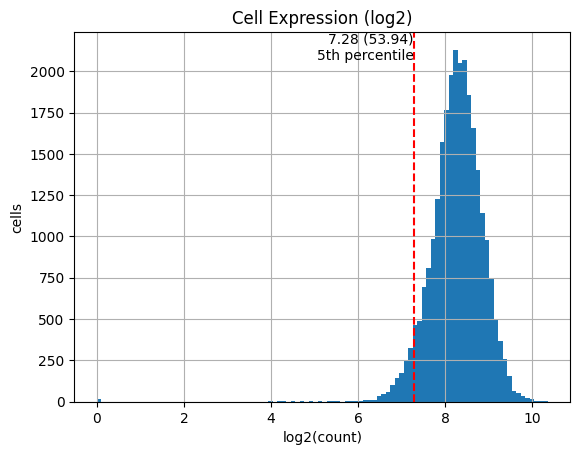

True     25417
False     1311
Name: count, dtype: int64

In [21]:
log_cell_expr = np.log2(cell_count.sum(axis=1) + 1)
min_expr = np.percentile(log_cell_expr, 5)
ax = log_cell_expr.hist(bins=100)
ax.axvline(min_expr, color="red", linestyle="--")
ax.text(
    min_expr,
    ax.get_ylim()[1],
    f"{min_expr:.2f} ({min_expr**2 + 1:.2f})\n5th percentile",
    ha="right",
    va="top",
)
plt.xlabel("log2(count)")
plt.ylabel("cells")
plt.title("Cell Expression (log2)")
plt.show()

valid_cells = log_cell_expr >= min_expr
valid_cells.value_counts()


In [22]:
# Filter cells
cell_area = cell_area[valid_cells]
cell_count = cell_count[valid_cells]

# filter condensates
cond_area = cond_area[valid_cells]
cond_count = cond_count[valid_cells]

# filter nucleus
nucleus_area = nucleus_area[valid_cells]
nucleus_count = nucleus_count[valid_cells]

# filter cytoplasms
cyto_area = cyto_area[valid_cells]
cyto_count = cyto_count[valid_cells]

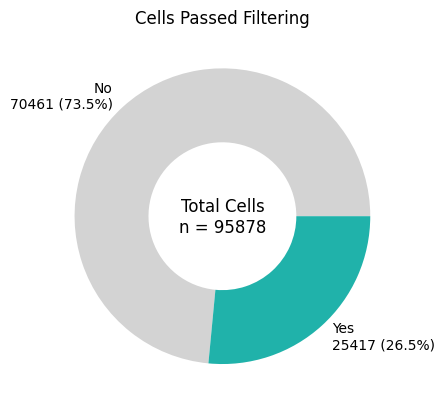

In [23]:
cell_mask = valid_cells & has_condensates
value_counts = {
    False: sdata["cellpose_boundaries"].shape[0] - len(cell_count),
    True: len(cell_count),
}

# Create labels with both count and percentage
labels = [
    f"No\n{value_counts[False]} ({value_counts[False] / len(cell_mask) * 100:.1f}%)",
    f"Yes\n{value_counts[True]} ({value_counts[True] / len(cell_mask) * 100:.1f}%)",
]

plt.pie(
    value_counts.values(),
    labels=labels,
    colors=["lightgrey", "lightseagreen"],
    wedgeprops={"width": 0.5},
)
# Total number of cells in center of pie
plt.text(
    0,
    0,
    f"Total Cells\nn = {len(has_condensates)}",
    ha="center",
    va="center",
    fontsize=12,
)
plt.title("Cells Passed Filtering")
plt.show()

## Filter genes with mean count > 3

In [24]:
cell_count_copy = cell_count.copy()
cell_count = cell_count.loc[:, cell_count_copy.mean() >= 3]
cond_count = cond_count.loc[:, cell_count_copy.mean() >= 3]
nucleus_count = nucleus_count.loc[:, cell_count_copy.mean() >= 3]
cyto_count = cyto_count.loc[:, cell_count_copy.mean() >= 3]

In [25]:
cell_count

,AKT3,BCL7A,CCND3,CD9,CLIP1,DCP1A,E2F7,EHD4,EIF2AK2,GPATCH11,...,PFKFB3,SAMHD1,SHISA5,SLC25A28,STAT1,SWAP70,TRIM25,UBXN1,WARS,ZC3HAV1
cellpose_img4,1,3,0,2,12,2,0,1,4,0,...,4,2,5,1,1,4,1,4,13,5
cellpose_img13,2,5,2,0,6,4,0,2,4,3,...,2,0,7,2,2,6,0,4,5,1
cellpose_img27,4,7,2,4,8,4,2,5,2,2,...,2,1,14,3,2,2,1,13,17,12
cellpose_img36,2,9,2,6,3,5,3,3,3,4,...,2,6,3,1,4,4,2,10,10,7
cellpose_img42,15,27,7,3,19,9,4,13,3,6,...,7,2,11,4,9,14,2,13,36,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cellpose_img95837,9,30,5,0,26,20,8,6,1,7,...,5,5,19,7,7,12,5,23,17,24
cellpose_img95863,5,21,2,1,8,15,4,3,4,2,...,7,1,25,7,6,3,2,13,13,7
cellpose_img95864,3,21,4,6,7,10,7,6,8,3,...,6,5,27,2,8,4,3,14,14,21
cellpose_img95869,5,11,4,0,7,3,2,4,4,6,...,3,2,13,4,8,2,0,14,11,13


# Compare compartments
- measure how transcripts are distributed across the cytoplasm and condensates relative to the cell
- compare area, count, and density at gene level

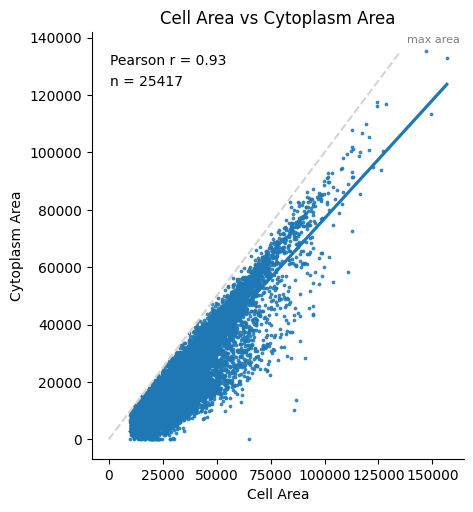

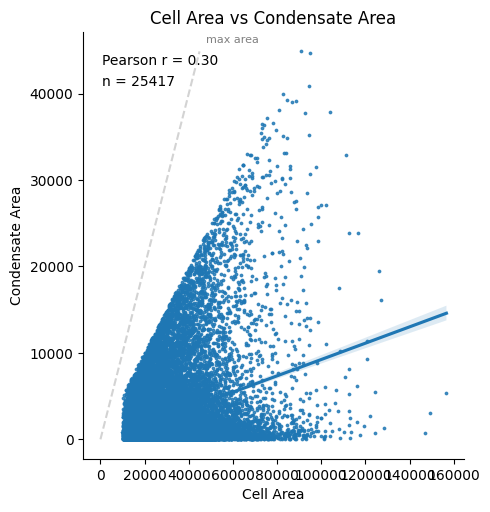

In [26]:
def plot_area_comparison(x_data, y_data, x_label, y_label):
    # Calculate Pearson correlation coefficient
    corr_coef = np.corrcoef(x_data, y_data)[0, 1]

    sns.lmplot(
        data=pd.DataFrame({x_label: x_data, y_label: y_data}),
        x=x_label,
        y=y_label,
        aspect=1,
        scatter_kws={"s": 3},  # Set dot size to 3
    )

    # Plot y=x line
    line_max = min(x_data.max(), y_data.max())
    plt.plot([0, line_max], [0, line_max], color="lightgrey", linestyle="--")

    # Annotate y=x line with "max_area"
    plt.annotate(
        "max area",
        xy=(line_max, line_max),
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=8,
        color="grey",
    )

    # Add correlation coefficient text to the plot
    plt.text(
        0.05,
        0.95,
        f"Pearson r = {corr_coef:.2f}",
        transform=plt.gca().transAxes,
        verticalalignment="top",
    )

    # Add text for number of cells
    plt.text(
        0.05,
        0.90,
        f"n = {len(x_data)}",
        transform=plt.gca().transAxes,
        verticalalignment="top",
    )

    plt.title(f"{x_label} vs {y_label}")


# Plot cell area vs cytoplasm area
plot_area_comparison(cell_area, cyto_area, "Cell Area", "Cytoplasm Area")

# Plot cell area vs condensate area
plot_area_comparison(cell_area, cond_area, "Cell Area", "Condensate Area")

# Density analysis
- divide transcript count by area to get transcript density

In [27]:
"""cond_area.to_csv("/mnt/d/ebola/area/cond_area.csv")
cyto_area.to_csv("/mnt/d/ebola/area/cyto_area.csv")
nucleus_area.to_csv("/mnt/d/ebola/area/nucleus_area.csv")
cell_area.to_csv("/mnt/d/ebola/area/cell_area.csv")"""

'cond_area.to_csv("/mnt/d/ebola/area/cond_area.csv")\ncyto_area.to_csv("/mnt/d/ebola/area/cyto_area.csv")\nnucleus_area.to_csv("/mnt/d/ebola/area/nucleus_area.csv")\ncell_area.to_csv("/mnt/d/ebola/area/cell_area.csv")'

In [28]:
"""cond_count.to_csv("/mnt/d/ebola/counts/cond_count.csv")
cyto_count.to_csv("/mnt/d/ebola/counts/cyto_count.csv")
nucleus_count.to_csv("/mnt/d/ebola/counts/nucleus_count.csv")
cell_count.to_csv("/mnt/d/ebola/counts/cell_count.csv")"""

'cond_count.to_csv("/mnt/d/ebola/counts/cond_count.csv")\ncyto_count.to_csv("/mnt/d/ebola/counts/cyto_count.csv")\nnucleus_count.to_csv("/mnt/d/ebola/counts/nucleus_count.csv")\ncell_count.to_csv("/mnt/d/ebola/counts/cell_count.csv")'

In [29]:
cond_density = cond_count.sum(axis=1).divide(cond_area).fillna(0.0)
cyto_density = cyto_count.sum(axis=1).divide(cyto_area).fillna(0.0)
nucleus_density = nucleus_count.sum(axis=1).divide(nucleus_area).fillna(0.0)
cell_density = cell_count.sum(axis=1).divide(cell_area).fillna(0.0)

In [30]:
"""cond_density.to_csv("/mnt/d/ebola/density/cond_density.csv")
cyto_density.to_csv("/mnt/d/ebola/density/cyto_density.csv")
nucleus_density.to_csv("/mnt/d/ebola/density/nucleus_density.csv")
cell_density.to_csv("/mnt/d/ebola/density/cell_density.csv")"""

'cond_density.to_csv("/mnt/d/ebola/density/cond_density.csv")\ncyto_density.to_csv("/mnt/d/ebola/density/cyto_density.csv")\nnucleus_density.to_csv("/mnt/d/ebola/density/nucleus_density.csv")\ncell_density.to_csv("/mnt/d/ebola/density/cell_density.csv")'

In [31]:
cond_density_normalized = cond_density.divide(cell_density).fillna(0.0)
cyto_density_normalized = cyto_density.divide(cell_density).fillna(0.0)
nucleus_density_normalized = nucleus_density.divide(cell_density).fillna(0.0)
cell_density_normalized = cell_density.divide(cell_density).fillna(0.0)

In [32]:
"""cond_density_normalized.to_csv("/mnt/d/ebola/density_ratio/cond_density_ratio.csv")
cyto_density_normalized.to_csv("/mnt/d/ebola/density_ratio/cyto_density_ratio.csv")
nucleus_density_normalized.to_csv(
    "/mnt/d/ebola/density_ratio/nucleus_density_ratio.csv"
)
cell_density_normalized.to_csv("/mnt/d/ebola/density_ratio/cell_density_ratio.csv")"""

'cond_density_normalized.to_csv("/mnt/d/ebola/density_ratio/cond_density_ratio.csv")\ncyto_density_normalized.to_csv("/mnt/d/ebola/density_ratio/cyto_density_ratio.csv")\nnucleus_density_normalized.to_csv(\n    "/mnt/d/ebola/density_ratio/nucleus_density_ratio.csv"\n)\ncell_density_normalized.to_csv("/mnt/d/ebola/density_ratio/cell_density_ratio.csv")'

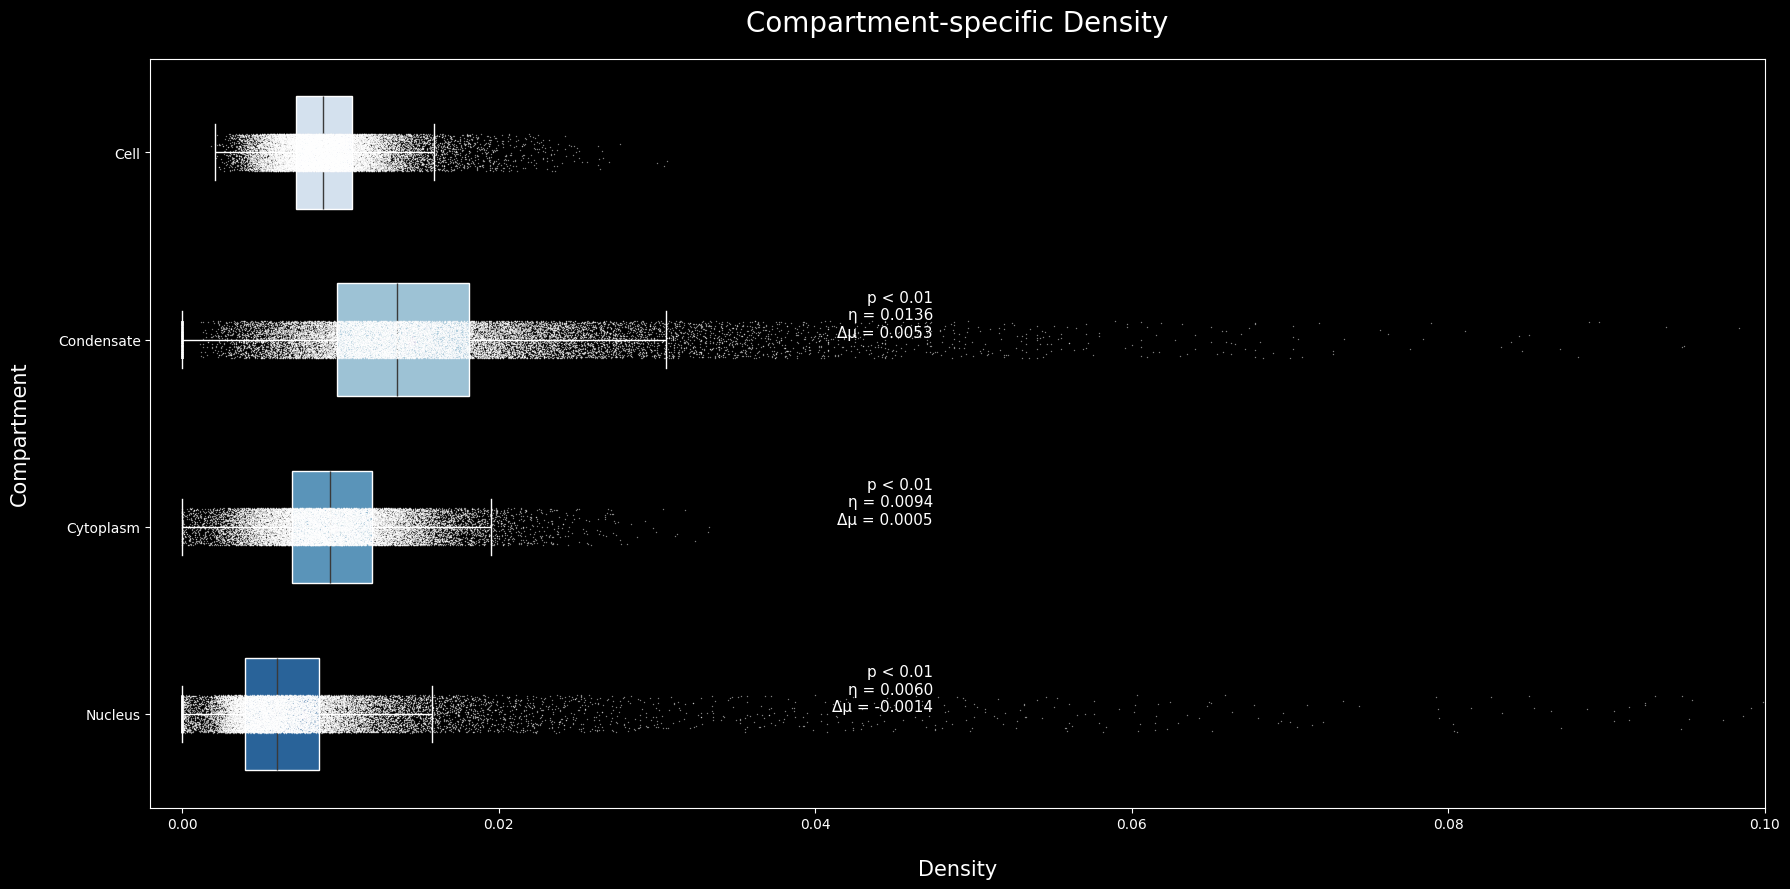

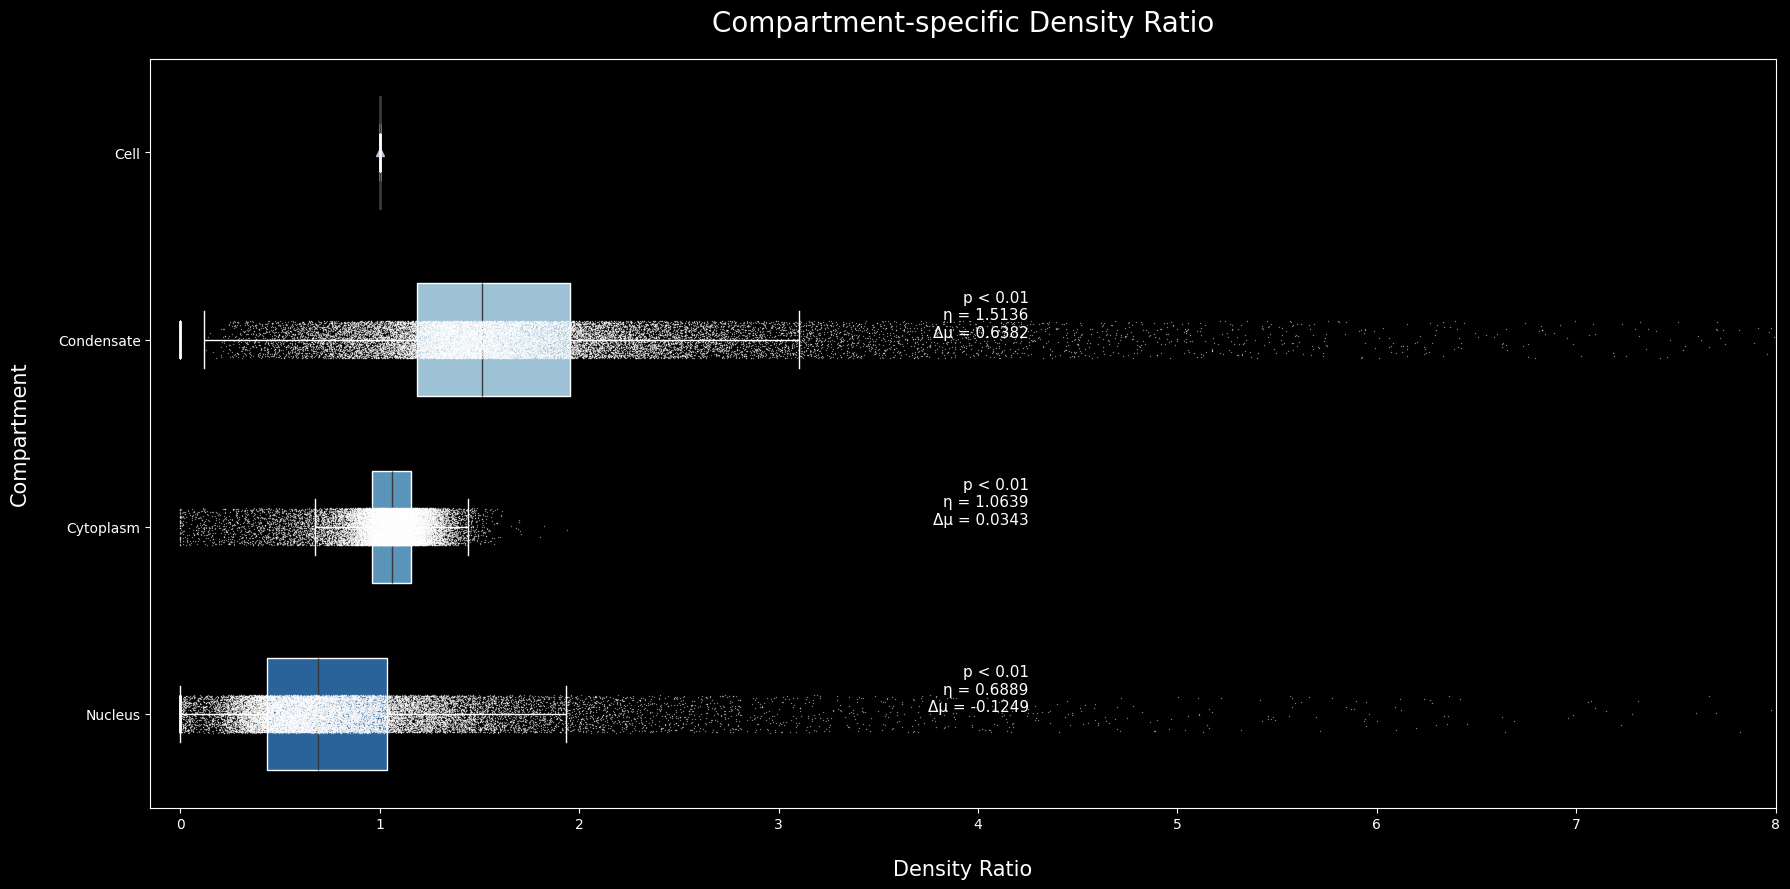

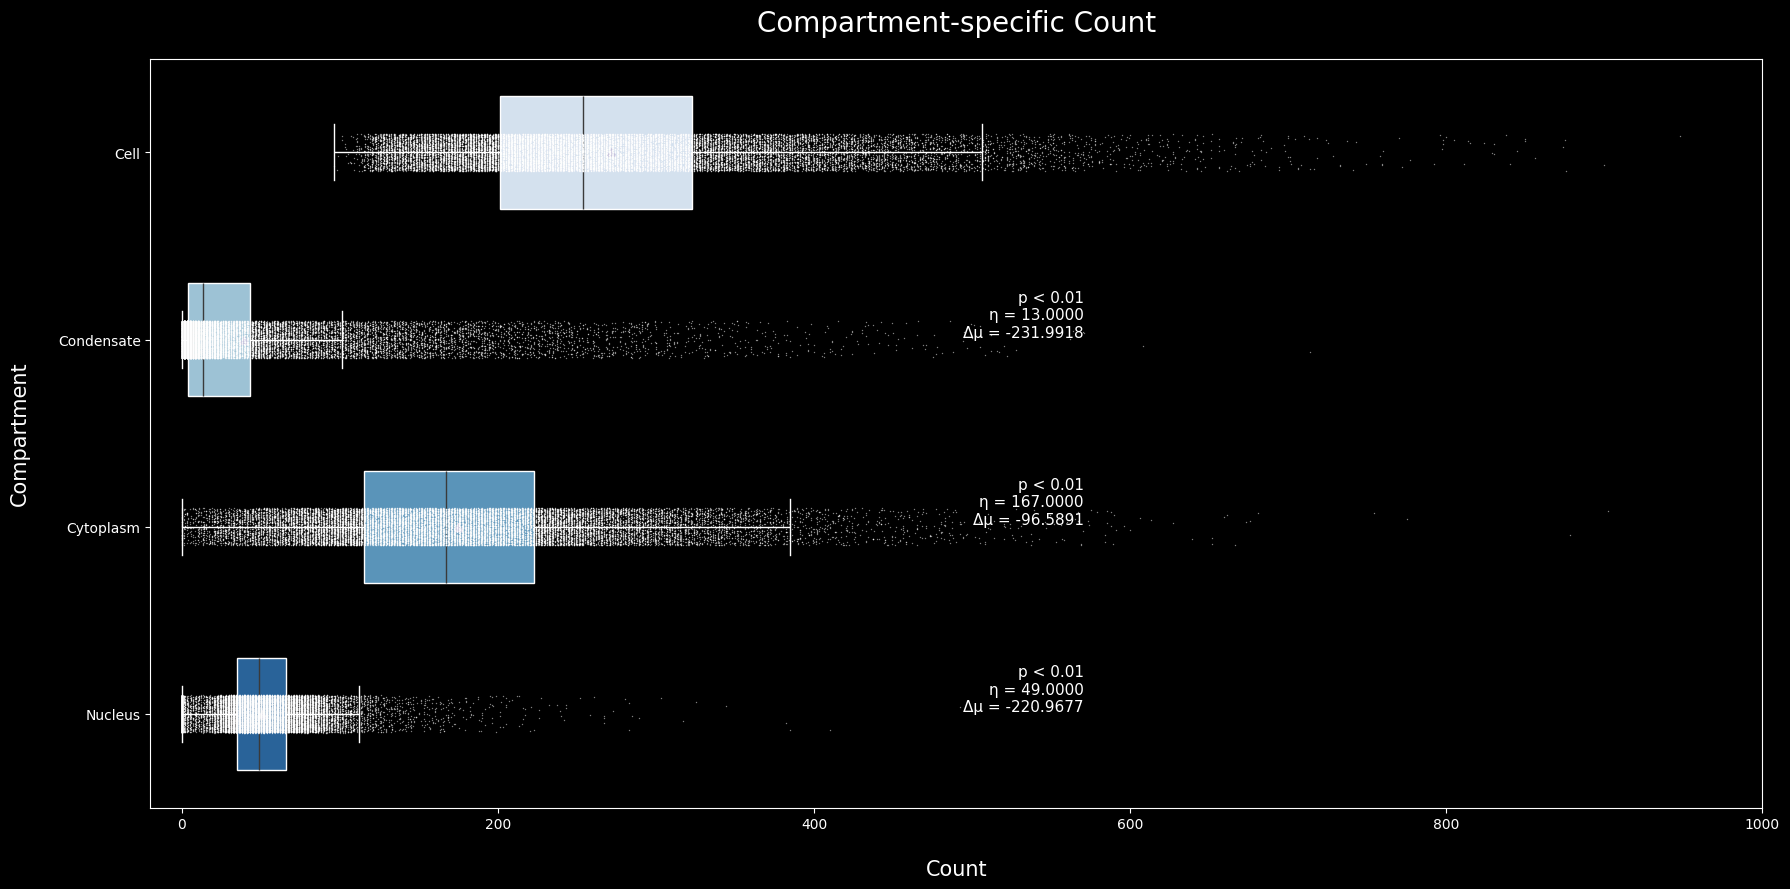

In [37]:
def compare_distributions(
    cell_data, cond_data, cyto_data, nucleus_data, metric="Density"
):
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    from scipy.stats import wilcoxon

    plt.style.use("dark_background")

    # Prepare the data
    data_long = pd.DataFrame(
        {
            metric: pd.concat([cell_data, cond_data, cyto_data, nucleus_data]),
            "Group": ["Cell"] * len(cell_data)
            + ["Condensate"] * len(cond_data)
            + ["Cytoplasm"] * len(cyto_data)
            + ["Nucleus"] * len(nucleus_data),
        }
    )
    data_long = data_long.reset_index(drop=True)

    # Compute Wilcoxon rank-sum test for each group against Cell
    cond_wstat, cond_pval = wilcoxon(cond_data, cell_data)
    cyto_wstat, cyto_pval = wilcoxon(cyto_data, cell_data)
    nucleus_wstat, nucleus_pval = wilcoxon(nucleus_data, cell_data)

    # Calculate mean differences
    cond_diff = cond_data.mean() - cell_data.mean()
    cyto_diff = cyto_data.mean() - cell_data.mean()
    nucleus_diff = nucleus_data.mean() - cell_data.mean()

    # Calculate median (Eta) values
    cond_median = cond_data.median()
    cyto_median = cyto_data.median()
    nucleus_median = nucleus_data.median()

    # Define the color palette
    palette = sns.color_palette("Blues", n_colors=4)

    # Create the plot
    plt.figure(figsize=(18, 9))

    # Box plot
    sns.boxplot(
        data=data_long,
        x=metric,
        y="Group",
        width=0.6,
        palette=palette,
        showmeans=True,  # Optionally show the mean line
        boxprops={"edgecolor": "white"},
        whiskerprops={"color": "white"},
        capprops={"color": "white"},
        showfliers=False,
    )

    # Strip plot
    sns.stripplot(
        data=data_long,
        x=metric,
        y="Group",
        color="white",
        size=1,
        jitter=0.1,  # Offset the points slightly for better visualization
        alpha=0.5,
    )

    # Add annotations for p-values, mean differences, and median (Eta)
    for i, (p_val, diff, label, median_val) in enumerate(
        [
            (nucleus_pval, nucleus_diff, "Nucleus", nucleus_median),
            (cyto_pval, cyto_diff, "Cytoplasm", cyto_median),
            (cond_pval, cond_diff, "Condensate", cond_median),
        ]
    ):
        if metric == "Count":
            if label != "Cell":  # Annotate only groups other than Cell
                if p_val < 0.01:
                    text = f"p < 0.01\nη = {median_val:.4f}\nΔμ = {diff:.4f}"
                else:
                    text = f"p = {p_val:.4f}\nη = {median_val:.4f}\nΔμ = {diff:.4f}"
                plt.text(
                    plt.gca().get_xlim()[1] * 0.5,
                    3 - i,  # Adjust the position based on the group order
                    text,
                    ha="right",
                    va="bottom",
                    fontsize=11,
                )
        elif metric == "Density":
            if label != "Cell":
                if p_val < 0.01:
                    text = f"p < 0.01\nη = {median_val:.4f}\nΔμ = {diff:.4f}"
                else:
                    text = f"p = {p_val:.4f}\nη = {median_val:.4f}\nΔμ = {diff:.4f}"
                plt.text(
                    plt.gca().get_xlim()[1] * 0.027,
                    3 - i,  # Adjust the position based on the group order
                    text,
                    ha="right",
                    va="bottom",
                    fontsize=11,
                )

        elif metric == "Density Ratio":
            if label != "Cell":
                if p_val < 0.01:
                    text = f"p < 0.01\nη = {median_val:.4f}\nΔμ = {diff:.4f}"
                else:
                    text = f"p = {p_val:.4f}\nη = {median_val:.4f}\nΔμ = {diff:.4f}"
                plt.text(
                    plt.gca().get_xlim()[1] * 0.035,
                    3 - i,  # Adjust the position based on the group order
                    text,
                    ha="right",
                    va="bottom",
                    fontsize=11,
                )

    # Set plot labels and title
    if metric == "Density":
        plt.xlabel(f"{metric}", fontsize=15, labelpad=20)
        plt.title(f"Compartment-specific {metric}", fontsize=20, pad=20)
        plt.xlim(-0.002, 0.1)
    if metric == "Density Ratio":
        plt.xlabel(f"{metric}", fontsize=15, labelpad=20)
        plt.title(f"Compartment-specific {metric}", fontsize=20, pad=20)
        plt.xlim(-0.15, 8)
    if metric == "Count":
        plt.xlabel(f"{metric}", fontsize=15, labelpad=20)
        plt.title(f"Compartment-specific {metric}", fontsize=20, pad=20)
        plt.xlim(-20, 1000)
    plt.ylabel("Compartment", fontsize=15, labelpad=20)
    plt.tight_layout()
    plt.legend([], [], frameon=False)  # Remove redundant legend
    plt.show()


# Compare densities
compare_distributions(
    cell_density,
    cond_density,
    cyto_density,
    nucleus_density,
    metric="Density",
)

# Compare density ratios
compare_distributions(
    cell_density_normalized,
    cond_density_normalized,
    cyto_density_normalized,
    nucleus_density_normalized,
    metric="Density Ratio",
)

# Compare counts
compare_distributions(
    cell_count.sum(axis=1),
    cond_count.sum(axis=1),
    cyto_count.sum(axis=1),
    nucleus_count.sum(axis=1),
    metric="Count",
)

## Filter by condensate to cytoplasm density ratio > 1

In [56]:
cond_gene_density = cond_count.divide(cond_area, axis=0)
cyto_gene_density = cyto_count.divide(cyto_area, axis=0)
nucleus_gene_density = nucleus_count.divide(nucleus_area, axis=0)
cell_gene_density = cell_count.divide(cell_area, axis=0)

In [57]:
density_ratio_filter = cond_gene_density.mean(axis=0) / cyto_gene_density.mean(axis=0)
density_ratio_filter

AKT3        1.950632
BCL7A       1.507288
CCND3       1.307411
CD9         1.494146
CLIP1       1.978301
DCP1A       1.555803
E2F7        1.559391
EHD4        1.343306
EIF2AK2     2.622782
GPATCH11    1.956668
HSPH1       1.515991
IARS        1.304903
LAP3        1.451517
MAP3K5      1.046321
MEX3A       1.241381
MOV10       1.086763
NFE2L1      1.362981
ODC1        1.896547
OTUD3       1.110463
PFKFB3      1.261399
SAMHD1      1.365518
SHISA5      1.399604
SLC25A28    1.116687
STAT1       1.318158
SWAP70      1.618118
TRIM25      1.421032
UBXN1       1.243753
WARS        1.386291
ZC3HAV1     1.304598
dtype: float64

## Grab enriched transcripts from Final Gene List

In [2]:
enriched_transcripts = list(cell_gene_density.columns)
enriched_transcripts = ["SCOTIN" if x == "SHISA5" else x for x in enriched_transcripts]
enriched_transcripts = ["ZAP" if x == "ZC3HAV1" else x for x in enriched_transcripts]
enriched_transcripts = ["PKR" if x == "EIF2AK2" else x for x in enriched_transcripts]

NameError: name 'cell_gene_density' is not defined

In [59]:
gene_panel_df = pd.read_csv(
    "FinalGeneList_AM1630_VS219_LJI_HEK293T_JF.xlsx.csv", index_col=0
)

In [60]:
enriched_df = gene_panel_df.loc[enriched_transcripts]
enriched_df

,alternative_gene_name,ensembl,source,Vizgen.Gene,Vizgen.FPKM,transcript,target_regions,isoform_length,sufficient_target_regions,overabundance,targetable,barcodeType
Gene,,,,,,,,,,,,
AKT3,NaN,ENSG00000117020,transcriptome,AKT3,102.590755,NM_005465.7,129.0,7281.0,True,False,True,merfish
BCL7A,NaN,ENSG00000110987,transcriptome,BCL7A,170.520624,NM_001024808.3,74.0,2581.0,True,False,True,merfish
CCND3,NaN,ENSG00000112576,transcriptome,CCND3,221.311330,NM_001760.5,50.0,2085.0,True,False,True,merfish
CD9,NaN,ENSG00000010278,transcriptome,CD9,113.836296,NM_001769.4,56.0,1225.0,True,False,True,merfish
CLIP1,NaN,ENSG00000130779,transcriptome,CLIP1,49.285231,NM_001247997.2,154.0,5568.0,True,False,True,merfish
DCP1A,NaN,ENSG00000272886,transcriptome,DCP1A,127.302779,NM_018403.7,99.0,5926.0,True,False,True,merfish
E2F7,NaN,ENSG00000165891,transcriptome,E2F7,78.439066,ENST00000322886,88.0,5725.0,True,False,True,merfish
EHD4,NaN,ENSG00000103966,transcriptome,EHD4,68.601797,NM_139265.4,155.0,6401.0,True,False,True,merfish
PKR,EIF2AK2,ENSG00000055332,rest,EIF2AK2,90.890078,NM_001135651.3,119.0,9975.0,True,False,True,merfish


## Pull Sequence from Ensembl ID

In [61]:
import requests
from Bio import Entrez, SeqIO, Seq


def get_sequence(ensembl_id_list, df):
    sequence = []
    sequence_length = []
    for id in ensembl_id_list:
        if id.startswith("E"):
            url = f"https://genome.cse.ucsc.edu/cgi-bin/hgGene?hgsid=2377472341_79sdEqaGAq0LUQ4tw1z0ngswVtzB&hgg_do_getMrnaSeq=1&hgg_gene={id}"
            response = requests.get(url)
            if response.status_code == 200:
                seq = response.text
                seq = seq.split("\n")
                seq = "".join(seq[2:-1])
                if id == "ENST00000606142.5_6":
                    seq = "GCGAGTAGTCGTCCGACGTCTGGCCGTGAGACGTTTCGGGAGCCGGAGTCTCTCCACCGCAGACATGACGAAGGGCCTTGTTTTAGGAATCTATTCCAAAGAAAAAGAAGATGATGTGCCACAGTTCACAAGTGCAGGAGAGAATTTTGATAAATTGTTAGCTGGAAAGCTGAGAGAGACTTTGAACATATCTGGACCACCTCTGAAGGCAGGGAAGACTCGAACCTTTTATGGTCTGCATCAGGACTTCCCCAGCGTGGTGCTAGTTGGCCTCGGCAAAAAGGCAGCTGGAATCGACGAACAGGAAAACTGGCATGAAGGCAAAGAAAACATCAGAGCTGCTGTTGCAGCGGGGTGCAGGCAGATTCAAGACCTGGAGCTCTCGTCTGTGGAGGTGGATCCCTGTGGAGACGCTCAGGCTGCTGCGGAGGGAGCGGTGCTTGGTCTCTATGAATACGATGACCTAAAGCAAAAAAAGAAGATGGCTGTGTCGGCAAAGCTCTATGGAAGTGGGGATCAGGAGGCCTGGCAGAAAGGAGTCCTGTTTGCTTCTGGGCAGAACTTGGCACGCCAATTGATGGAGACGCCAGCCAATGAGATGACGCCAACCAGATTTGCTGAAATTATTGAGAAGAATCTCAAAAGTGCTAGTAGTAAAACCGAGGTCCATATCAGACCCAAGTCTTGGATTGAGGAACAGGCAATGGGATCATTCCTCAGTGTGGCCAAAGGATCTGACGAGCCCCCAGTCTTCTTGGAAATTCACTACAAAGGCAGCCCCAATGCAAACGAACCACCCCTGGTGTTTGTTGGGAAAGGAATTACCTTTGACAGTGGTGGTATCTCCATCAAGGCTTCTGCAAATATGGACCTCATGAGGGCTGACATGGGAGGAGCTGCAACTATATGCTCAGCCATCGTGTCTGCTGCAAAGCTTAATTTGCCCATTAATATTATAGGTCTGGCCCCTCTTTGTGAAAATATGCCCAGCGGCAAGGCCAACAAGCCGGGGGATGTTGTTAGAGCCAAAAACGGGAAGACCATCCAGGTTGATAACACTGATGCTGAGGGGAGGCTCATACTGGCTGATGCGCTCTGTTACGCACACACGTTTAACCCGAAGGTCATCCTCAATGCCGCCACCTTAACAGGTGCCATGGATGTAGCTTTGGGATCAGGTGCCACTGGGGTCTTTACCAATTCATCCTGGCTCTGGAACAAACTCTTCGAGGCCAGCATTGAAACAGGGGACCGTGTCTGGAGGATGCCTCTCTTCGAACATTATACAAGACAGGTTGTAGATTGCCAGCTTGCTGATGTTAACAACATTGGAAAATACAGATCTGCAGGAGCATGTACAGCTGCAGCATTCCTGAAAGAATTCGTAACTCATCCTAAGTGGGCACATTTAGACATAGCAGGCGTGATGACCAACAAAGATGAAGTTCCCTATCTACGGAAAGGCATGACTGGGAGGCCCACAAGGACTCTCATTGAGTTCTTACTTCGTTTCAGTCAAGACAATGCTTAGTTCAGATACTCAAAAATGTCTTCACTCTGTCTTAAATTGGACAGTTGAACTTAAAAGGTTTTTGAATAAATGGATGAAAATCTTTTAACGGAGACAAAGGATGGTATTTAAAAATGTAGAACACAATGAAATTTGTATGCCTTGATTTTTTTTTCATTTCACACAAAGATTTATAAAGGTAAAGTTAATATCTTACTTGATAAGGATTTTTAAGATACTCTATAAATGATTAAAATTTTTAGAACTTCCTAATCACTTTTCAGAGTATATGTTTTTCATTGAGAAGCAAAATTGTAACTCAGATTTGTGATGCTAGGAACATGAGCAAACTGAAAATTACTATGC"
                sequence.append(seq)
                sequence_length.append(len(seq))
            else:
                print(f"Error fetching gene sequence: {response.status_code}")
                return None
        else:
            try:
                with Entrez.efetch(
                    db="nucleotide", id=id, rettype="fasta", retmode="text"
                ) as handle:
                    record = SeqIO.read(handle, "fasta")
                    sequence.append(str(record.seq))
                    sequence_length.append(len(record.seq))
            except Exception as e:
                print(f"Error fetching data for {id}: {e}")
                return None
    df["sequence"] = sequence
    df["sequence_length"] = sequence_length
    return df

In [62]:
enriched_df = get_sequence(enriched_df["transcript"], enriched_df)

In [63]:
enriched_df

,alternative_gene_name,ensembl,source,Vizgen.Gene,Vizgen.FPKM,transcript,target_regions,isoform_length,sufficient_target_regions,overabundance,targetable,barcodeType,sequence,sequence_length
Gene,,,,,,,,,,,,,,
AKT3,NaN,ENSG00000117020,transcriptome,AKT3,102.590755,NM_005465.7,129.0,7281.0,True,False,True,merfish,GCAGCCCTTCGCTTGCCCTCCCGCCGGCCGCACCGGGCTCCAGGAG...,7281
BCL7A,NaN,ENSG00000110987,transcriptome,BCL7A,170.520624,NM_001024808.3,74.0,2581.0,True,False,True,merfish,GCACTGGGCCAGGCGCGCGGCGGCCCCGGGCTTTGTGTGTGTGTGT...,3722
CCND3,NaN,ENSG00000112576,transcriptome,CCND3,221.311330,NM_001760.5,50.0,2085.0,True,False,True,merfish,GTCAGGGAAGCGGCGCGCGCGCGCGGGCGGCGGGCGGGCTGGGGAT...,2026
CD9,NaN,ENSG00000010278,transcriptome,CD9,113.836296,NM_001769.4,56.0,1225.0,True,False,True,merfish,AGCCGCCTGCATCTGTATCCAGCGCCAGGTCCCGCCAGTCCCAGCT...,1225
CLIP1,NaN,ENSG00000130779,transcriptome,CLIP1,49.285231,NM_001247997.2,154.0,5568.0,True,False,True,merfish,AGCGCGCGCCCGCCCGGCCCCGCGGCGGCGGCGGCGCGTCACGCTC...,5978
DCP1A,NaN,ENSG00000272886,transcriptome,DCP1A,127.302779,NM_018403.7,99.0,5926.0,True,False,True,merfish,AGAGGGGCTAGGCTCTGGGATTCAAGATGGAGGCGCTGAGTCGAGC...,5926
E2F7,NaN,ENSG00000165891,transcriptome,E2F7,78.439066,ENST00000322886,88.0,5725.0,True,False,True,merfish,<HTML><HEAD><meta http-equiv='Content-Security...,2308
EHD4,NaN,ENSG00000103966,transcriptome,EHD4,68.601797,NM_139265.4,155.0,6401.0,True,False,True,merfish,AGTGCGAGCCGGGGAGAGTCGAACCCGGAGCAGGGTCCCATCCGAG...,6401
PKR,EIF2AK2,ENSG00000055332,rest,EIF2AK2,90.890078,NM_001135651.3,119.0,9975.0,True,False,True,merfish,GAAACTGAGAACCAGCTCTCCCGAAGCCGCGGGTCTCCGGCCGGCG...,9975


In [64]:
def gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    gc_percentage = (gc_count / len(sequence)) * 100 if len(sequence) > 0 else 0
    return gc_percentage


enriched_df["GC_Content"] = enriched_df["sequence"].apply(gc_content)


In [65]:
enriched_df[
    [
        "transcript",
        "alternative_gene_name",
        "isoform_length",
        "sequence",
        "sequence_length",
        "GC_Content",
    ]
]

,transcript,alternative_gene_name,isoform_length,sequence,sequence_length,GC_Content
Gene,,,,,,
AKT3,NM_005465.7,NaN,7281.0,GCAGCCCTTCGCTTGCCCTCCCGCCGGCCGCACCGGGCTCCAGGAG...,7281,41.052053
BCL7A,NM_001024808.3,NaN,2581.0,GCACTGGGCCAGGCGCGCGGCGGCCCCGGGCTTTGTGTGTGTGTGT...,3722,53.734551
CCND3,NM_001760.5,NaN,2085.0,GTCAGGGAAGCGGCGCGCGCGCGCGGGCGGCGGGCGGGCTGGGGAT...,2026,59.970385
CD9,NM_001769.4,NaN,1225.0,AGCCGCCTGCATCTGTATCCAGCGCCAGGTCCCGCCAGTCCCAGCT...,1225,45.061224
CLIP1,NM_001247997.2,NaN,5568.0,AGCGCGCGCCCGCCCGGCCCCGCGGCGGCGGCGGCGCGTCACGCTC...,5978,44.379391
DCP1A,NM_018403.7,NaN,5926.0,AGAGGGGCTAGGCTCTGGGATTCAAGATGGAGGCGCTGAGTCGAGC...,5926,43.840702
E2F7,ENST00000322886,NaN,5725.0,<HTML><HEAD><meta http-equiv='Content-Security...,2308,0.606586
EHD4,NM_139265.4,NaN,6401.0,AGTGCGAGCCGGGGAGAGTCGAACCCGGAGCAGGGTCCCATCCGAG...,6401,51.820028
PKR,NM_001135651.3,EIF2AK2,9975.0,GAAACTGAGAACCAGCTCTCCCGAAGCCGCGGGTCTCCGGCCGGCG...,9975,38.506266


In [ ]:
found_sequences = [
    "AKT3",
    "CD9",
    "DCP1A",
    "EHD4",
    "PKR",
    "HSPH1",
    "LAP3",
    "MAP3K5",
    "MEX3A",
    "NFE2L1",
    "ODC1",
    "OTUD3",
    "SCOTIN",
    "SLC25A28",
    "SWAP70",
    "TRIM25",
]
found_enriched_df = enriched_df.loc[found_sequences]

In [ ]:
'''with open("/mnt/d/ebola/work/RNAfold/RNAfold.fa", "w") as fasta_file:
    for gene, row in found_enriched_df.iterrows():
        header = f">{gene}_{row['transcript']}\n"
        sequence = f"{row['sequence']}\n"
        fasta_file.write(header)
        fasta_file.write(sequence)'''